In [1]:
from env import *
from env_tradestation import *
from data_retriever_simple import Client
import acquire
import prepare
import model

import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

# Predicting cryptocurrency returns using machine learning and ARIMA models

## Summary

I compared the forecasting ability of regression, classification and ARIMA models to predict returns for Bitcoin.  I developed a pipeline for ingesting price data from the Coinbase online API, cleaning the data in preparation for modeling, determining useful features via statistical testing and visualization, and iterating through multiple models to ultimately come up with profitable trading strategies. I roughly followed the methodology used by Helder Sebastiao and Pedro Godinho in their article "Forecasting and trading cryptocurrencies with machine learning under changing market conditions," published 06 Jan 2021 (https://rdcu.be/cMaLB). Though I did not find that the features used in the study showed correlation with Bitcoin returns based on visualization and statistical testing, using them as inputs to the machine learning models did result in positive average returns. Model performance using standard train/validate/test data splitting (multi-step forecasting) was superior to single-step forecasting (that used in the study).

###  Acquire Bitcoin Data Using Coinbase Pro API (account and API key required) or cached csv

In [2]:
results = acquire.get_data_from_csv()

### Prepare Data:
- Data came fairly clean from Coinbase, without any missing values
- The minimum low value for the dataset was suspiciously low. Further investigation found that there were system maintenance issues on 2017-04-15 with Coinbase. Because the low value is used to calculate a feature, 1-minute data was acquired for that day and the actual low determined and filled in for the erroneous value.  

In [3]:
prepared_results = prepare.prepare_crypto_data(results)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15


### Bitcoin Price Exploration

In [4]:
btc = prepared_results['BTC_USD']

In [5]:
# Adds target and features based on study by Sebastiao and Godinho
btc = prepare.add_features(btc)

In [6]:
btc.index.min()

Timestamp('2016-08-24 00:00:00')

In [7]:
btc.index.max()

Timestamp('2022-04-21 00:00:00')

### Split into train, validate, test

In [8]:
train_size = int(len(btc) * .5)
validate_size = int(len(btc) * .3)
test_size = int(len(btc) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = btc[: train_size]
validate = btc[train_size : validate_end_index]
test = btc[validate_end_index : ]

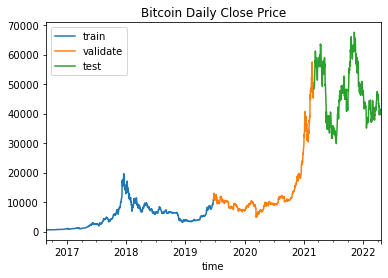

In [9]:
train.close.plot(label='train')
validate.close.plot(label='validate')
test.close.plot(label='test')
plt.title('Bitcoin Daily Close Price')
plt.legend()

### Differences in split samples:
- Both train and validate include a huge runup, though only train has a large crash afterward
- Test includes a crash from highs in 2021 followed by new all time highs later in the year followed by another crash
- Price dynamics are dramatically different from one sample to another, which would make any positive results more robust

### Target exploration:
- Regression target is forward log returns, which is the difference in close from tomorrow to today
- Classification target is whether next close is positive
- Log returns used (vs absolute prices) so can compare between different time series

Text(0, 0.5, 'Frequency of Return')

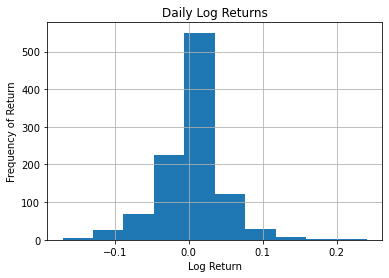

In [10]:
train.fwd_log_ret.hist()
plt.title('Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency of Return')

Text(0.5, 1.0, 'Next Close Positive (Classification Target) - fairly balanced')

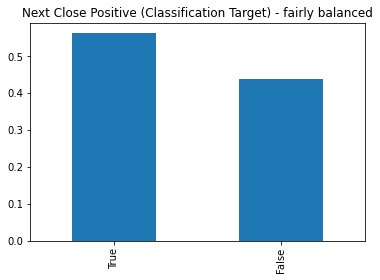

In [11]:
train.fwd_close_positive.value_counts(normalize=True).plot.bar()
plt.title('Next Close Positive (Classification Target) - fairly balanced')

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

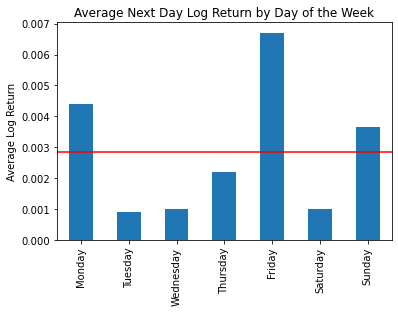

In [12]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
train.groupby(train.index.day_name()).fwd_log_ret.mean().loc[order].plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.title('Average Next Day Log Return by Day of the Week')
plt.ylabel('Average Log Return')
plt.xlabel("")
None

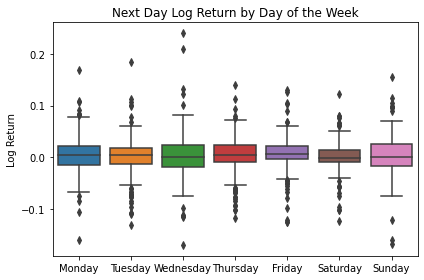

In [13]:
sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel("")
plt.ylabel("Log Return")
plt.title("Next Day Log Return by Day of the Week")
plt.tight_layout()


In [14]:
# Set alpha to 0.05
alpha = 0.05
overall_mean = train.fwd_log_ret.mean()
# Perform t-test to determine if any day's average return is significantly different from overall average
for day_of_the_week in train.index.day_name().unique():
    sample = train[train.index.day_name() == day_of_the_week]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(day_of_the_week, t, p<alpha)

Wednesday -0.4382109049371638 False
Thursday -0.19071391435173793 False
Friday 1.2220108640716778 False
Saturday -0.6757647160605057 False
Sunday 0.22803172561984486 False
Monday 0.45829650036842684 False
Tuesday -0.5432212034679261 False


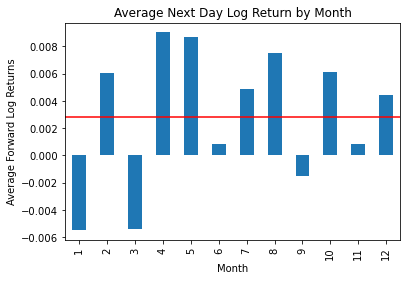

In [15]:
train.groupby(train.index.month).fwd_log_ret.mean().plot.bar()
plt.axhline(train.fwd_log_ret.mean(), color = 'r')
plt.title('Average Next Day Log Return by Month')
plt.xlabel('Month')
plt.ylabel('Average Forward Log Returns')
None

In [16]:
overall_mean = train.fwd_log_ret.mean()
for month_of_year in train.index.month.unique():
    sample = train[train.index.month == month_of_year]
    t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
    print(month_of_year, t, p<alpha)

8 1.2273269594973495 False
9 -1.1243058735938383 False
10 1.3046282286404267 False
11 -0.4214624142362868 False
12 0.2842678944628774 False
1 -1.636415104926473 False
2 0.6457455426399578 False
3 -2.0085106074230747 True
4 1.6800486284375764 False
5 1.4088257328256801 False
6 -0.4410689548599772 False
7 0.29825054760730546 False


### Takeaways:
- All days exhibit positive log returns for the next day on average
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- Notwithstanding the above bullet, no day's returns are statistically different from the overall mean based on a the t-test
- Wednesday and Sunday have the widest spread in values, suggesting Monday and Thursday are some of the more volatile days of the week
- No month except March exhibits average returns significantly different from the overall mean

### Does the target exhibit seasonal tendencies?

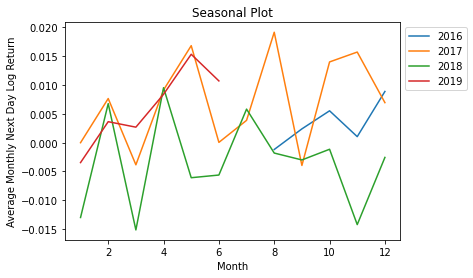

In [17]:
train.fwd_log_ret.groupby([train.index.year, train.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
plt.xlabel("Month")
plt.ylabel("Average Monthly Next Day Log Return")
plt.legend(bbox_to_anchor=(1, 1))

### Takeaways:
- February - April exhibit some seasonality. Every March there appears to be a big dip in returns, followed by big bounce up in April
- No other months appear to show seasonality

## Lag plots and Autocorrelation

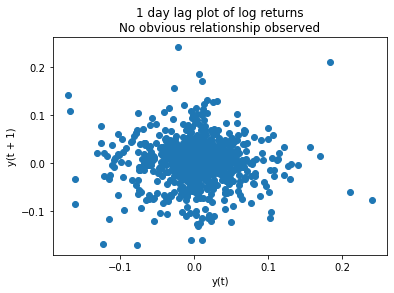

In [18]:
pd.plotting.lag_plot(train.fwd_log_ret, lag = 1)
plt.title('1 day lag plot of log returns\nNo obvious relationship observed')
None

### Lag plot of close price

Text(0.5, 1.0, '1 day lag plot of close price - today predicts tomorrow?')

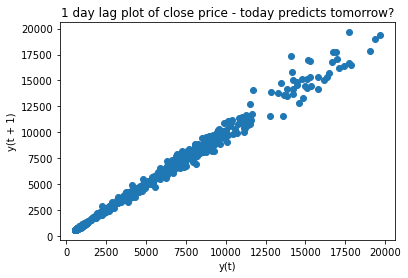

In [19]:
pd.plotting.lag_plot(train.close, lag = 1)
plt.title('1 day lag plot of close price - today predicts tomorrow?')

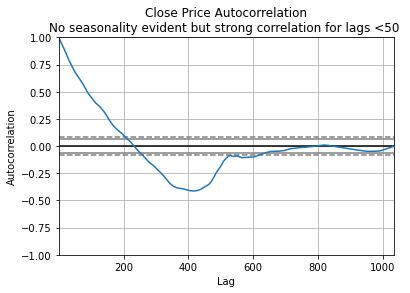

In [20]:
pd.plotting.autocorrelation_plot(train.close)
plt.title('Close Price Autocorrelation\nNo seasonality evident but strong correlation for lags <50 ')
None

### Features vs target

Text(0.5, 0, 'Relative Price Range')

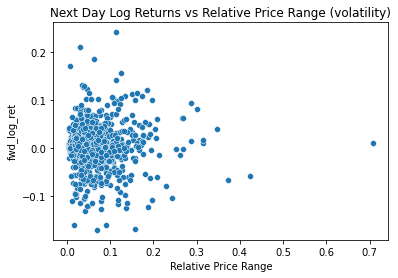

In [21]:
sns.scatterplot(train.RR, train.fwd_log_ret)
plt.title('Next Day Log Returns vs Relative Price Range (volatility)') 
plt.xlabel('Relative Price Range')

### Correlations of features vs target

In [22]:
# Check correlation of every feature besides encoded day name columns
train[[col for col in train.columns if 'day_name' not in col]].corrwith(train.fwd_log_ret).sort_values(ascending=False)

fwd_log_ret           1.000000
fwd_pct_chg           0.998712
fwd_ret               0.827821
fwd_close_positive    0.667871
log_ret_lag_6         0.049871
sigma_lag_6           0.047553
sigma_lag_2           0.045426
log_ret_lag_5         0.037157
log_ret_lag_7         0.036887
log_ret_lag_3         0.031387
volume                0.031338
log_ret_lag_2         0.020126
RR                    0.018527
sigma_lag_1           0.018403
sigma_lag_7           0.015279
sigma_lag_3           0.012200
log_ret_lag_4         0.005556
log_ret_lag_1        -0.011469
pct_chg              -0.012351
sigma_lag_4          -0.016418
sigma_lag_5          -0.039582
close                -0.065933
high                 -0.066128
low                  -0.066747
open                 -0.068015
dtype: float64

## Exploration Summary:
- Average log returns vary widely depending on the day of the week and month of the year
    - Daily dummies are included as modeling inputs
- Returns do not appear to follow any seasonal tendencies
- No features exhibit strong correlation with the regression target
- Lag and autocorrelation plots of log returns do not show that future returns are correlation with past returns
- Lag and autocorrelation plots of close price show a correlation with lags <50

# Modeling

- 11 different models were used to test the predictability of bitcoin prices:
    - ARMA(2,1)
    - 5 Regression models: Decision Tree Regressor,  SVR, LinearRegression, Tweedie Regressor, and LassoLars 
        - For SVR the non-default hyperparameters used were kernel='linear' and gamma=0.1
        - For all other models default hyperparameters from Scikit-Learn were used
    - 5 Classification models: 
        - Logistic Regression: C=10
        - Decision Tree Classifier 
        - KNeighbors Classifier: n_neighbors=10 
        - KNeighbors Classifier: n_neighbors=100
        - KNeighbors Classifier: n_neighbors=1000
- The regression and classification models were evaluated using both the traditional train, validate, test split used for exploration above as well as a rolling window approach for single-step forecasting. The ARMA model performs single-step forecasting.
- In addition to the standard RMSE and Accuracy score metrics an average trade was calculated and used to determine the best performance on validate for later use on the withheld test set.
    - Average trade was calculated as follows:
        - For regression models, long trade used for positive sign, short trade used for negative sign
        - For classification models, long trade used for True, short trade used for False
        - The trade is assumed to be opened on the prediction day's close and closed on the next day's close, so return is: (tomorrow's close - today's close) for long trade and (today's close - tomorrow's close) for short trades
- No transaction costs were considered
- Separate baseline methodologies were used for comparing regression and classification model results, though the actual baseline values were equivalent:
    - Regression: Entering long on every close and exiting at the next close
    - Classification: Using the mode of the target (fwd_close_positive) from the train set, which was True, as the prediction for every value. Therefore this also resulted in entering long on every close and exiting at the next close.

### ARIMA

##### Determine order of ARIMA to use

In [23]:
result=adfuller(train.fwd_log_ret)
print("AD Fuller p stat < 0.05", result[1]<0.05)

AD Fuller p stat < 0.05 True


#### Augmented Dickey-Fuller test results suggest time series does not have a unit root - > it is stationary. No differencing required.

##### Determine AR (p) term

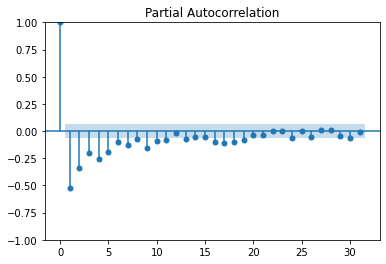

In [24]:
plot_pacf(train.fwd_log_ret.diff().dropna())
plt.show()

#### Lags from 1-10 are significant. Will test 0<p<11

##### Autocorrelation plot - MA (q) term

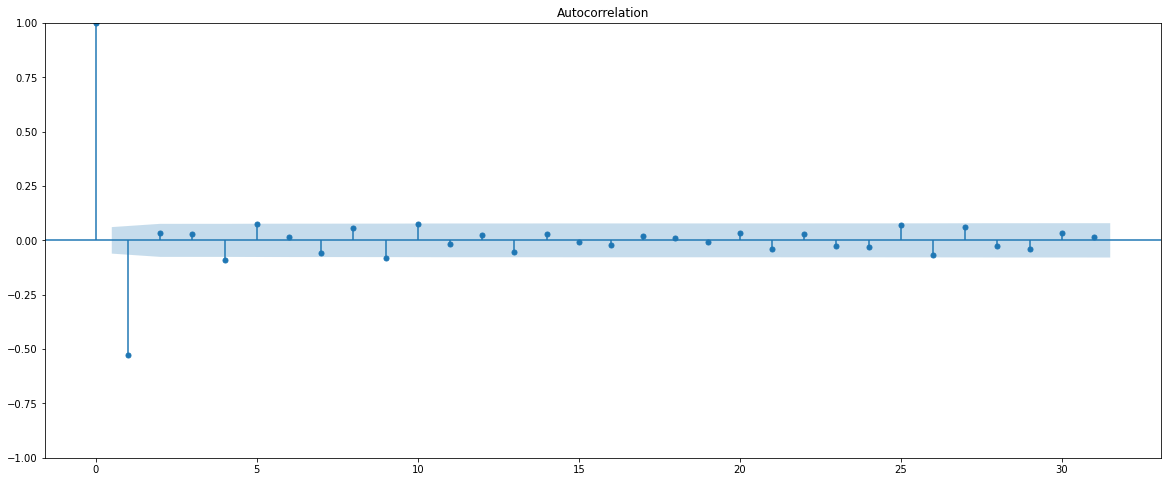

In [25]:
plt.rcParams.update({'figure.figsize':(20,8)})
plot_acf(train.fwd_log_ret.diff().dropna())
plt.show()

#### Set q as 1

### Run the ARIMA model evaluation

In [26]:
p_values = [2]
d_values = [0]
q_values = [1]
# time consuming !!! 
results_df = model.evaluate_models(train, validate, 'fwd_log_ret', p_values, d_values, q_values)

	Testing (2, 0, 1) 619/620



In [27]:
real = results_df.sort_values('mse').test_actual.array[0]

results_df['rmse']= results_df.mse**0.5

results_df.sort_values('rmse')

,p,d,q,mse,test_predictions,test_actual,rmse
0,2,0,1,0.001817,"[0.0065101283954541594, 0.005818612746221494, ...",time 2019-06-23 0.018230 2019-06-24 0.06...,0.042623


### Best ARIMA models (Running the ARIMA model is very time consuming so only summary is included here. Functions included in model.py to evaluate different p,d, and q values.):
- p values < 5
- Orders (2,1) and (3,1) resulted in RMSEs of 0.042623 and 0.042661

In [28]:
# Build dataframe with results from top ARIMA model to determine average trade
arima_results = pd.DataFrame(index = validate.index)
arima_results["predictions"] = results_df.head(1).test_predictions[0]
arima_results["actual"] = results_df.head(1).test_actual[0].array
arima_results["close"] = validate.close
arima_results["next_day_close"] = validate.close.shift(-1)
# Create a column saying whether we would go long or not (short) based on the 
arima_results["go_long"] = arima_results['predictions']>0
# Calculate the return that day (assumes always goes long or short every day)
arima_results["ret"] = np.where(arima_results["go_long"], arima_results.next_day_close-arima_results.close, arima_results.close-arima_results.next_day_close)

print(f"Average trade based on ARMA (2,1): {arima_results.ret.mean():.2f}")

Average trade based on ARMA (2,1): 48.75


#### ARMA results show decent trade performance.

### Using Regression and Classification Models

#### Features to be used as inputs:
- log returns lagged by 1-7 days
- Relative Price Range (RR) volatility indicator (for t lags 1-7):
    - 2$\frac{H_t-L_t}{H_t+L_t}$
- Parkinson range volatility estimator $\sigma$ (for t lags 1-7):
    - $\sigma$ = $\sqrt{\frac{(ln(H_t/L_t))^2}{(4*ln(2))}}$
- Day of the week dummy variables

In [29]:
# All available features are used to start
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
# List of features to scale
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']
# Specifying the target is necessary as regression and classification have different targets
target = 'fwd_log_ret'

# Return scaled datasets
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = model.scale_datasets(train, validate, test, target, features_to_use, features_to_scale)

### Iterate through regression models, uses existing train, validate, test split

In [30]:
# Specify regression models to test. Feature selection using recursive feature elimination is also available.
reg_models = [DecisionTreeRegressor(),  SVR(kernel='linear',gamma=0.1,), LinearRegression(), TweedieRegressor(), LassoLars()]
# Fits model using train and gets predictions for validate
rmses_train, rmses_validate, y_train, y_validate = model.predict_regression(reg_models, X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, perform_feature_selection=False)
# Consolidates results into dataframe. Outputs average trade information for each model.
avg_trade_model_results =  model.calculate_regression_results(reg_models, rmses_train, rmses_validate, validate, y_validate)

DecisionTreeRegressor
SVR(gamma=0.1, kernel='linear')
LinearRegression
TweedieRegressor
LassoLars
DecisionTreeRegressor 87.8
SVR(gamma=0.1, kernel='linear') 8.67
LinearRegression 84.36
TweedieRegressor 69.43
LassoLars 63.86


### Iterate through classification models, uses existing train, validate, test split

In [31]:
class_models = [LogisticRegression(C=10), 
                DecisionTreeClassifier(max_depth=None),
                KNeighborsClassifier(n_neighbors=10), 
                KNeighborsClassifier(n_neighbors=100), 
                KNeighborsClassifier(n_neighbors=1000)]

# Define the target as the binary option
y_train = train[['fwd_close_positive']]
y_validate = validate[['fwd_close_positive']]

# Perform predictions
accuracies_train, accuracies_validate, y_train, y_validate = model.predict_classification(class_models, X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, perform_feature_selection=False)
# Put results into dataframe
class_avg_trade_model_results =  model.calculate_classification_results(class_models, accuracies_train, accuracies_validate, validate, y_validate)

LogisticRegression(C=10)
DecisionTreeClassifier
KNeighborsClassifier(n_neighbors=10)
KNeighborsClassifier(n_neighbors=100)
KNeighborsClassifier(n_neighbors=1000)
LogisticRegression(C=10) 28.98
DecisionTreeClassifier 28.76
KNeighborsClassifier(n_neighbors=10) 6.39
KNeighborsClassifier(n_neighbors=100) 41.37
KNeighborsClassifier(n_neighbors=1000) 63.86


In [32]:
# Add classification results from standard data split
avg_trade_model_results = avg_trade_model_results.append(class_avg_trade_model_results)

## Alternative data split - perform modeling using one-step ahead forecasting (rolling window)
- Each log return in validate is predicted using a model trained on the preceding 1033 observerations (length of train)
- After making the prediction the first row used for train is removed and the last validate row is added to the train set
- The result is a prediction for each validate day that is compared to the actual value of log return

### Regression models - single step forecasting

In [33]:
target = 'fwd_log_ret'
y_train = train[[target]]
y_validate = validate[[target]]

reg_model_results = {}

# Specify regression models to test. Feature selection using recursive feature elimination is also available.
reg_models = [DecisionTreeRegressor(),  SVR(kernel='linear',gamma=0.1,), LinearRegression(), TweedieRegressor(), LassoLars()]

for model_under_test in reg_models:
    
    model_name = model_under_test.__repr__().split('()')[0]
    
    # Perform rolling predictions
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(X_train_scaled, X_validate_scaled, y_train, y_validate, model_under_test, 'fwd_log_ret')
    
    # Calculate validate RMSE
    validate_rmse = mean_squared_error(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions], squared=False)
    
    print(model_name,"avg validate rmse",validate_rmse)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    # Set result index to validate's index
    validate_res.index = validate.index
    
    # Transfer close values over to results dataframe to allow for return calculation
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column for whether we would go long or not (short) based on the sign of the predictions value
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)
    
    # Store validate results in dictionary
    reg_model_results[model_name] = validate_res
    reg_model_results[model_name+"_rmse"] = validate_rmse



DecisionTreeRegressor avg validate rmse 0.06043352377107349 2021-03-02
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.04654232229653415521-03-02
LinearRegression avg validate rmse 0.0434349044883176262021-03-02
TweedieRegressor avg validate rmse 0.0428530217936425942021-03-02
LassoLars avg validate rmse 0.0428684732596698662021-03-02


#### Consolidate results into dataframe

In [34]:
# Create dataframe of results and append to existing results dataframe
avg_trades = []
rmses = []
indices = []
# iterate through each key in regression model results dictionary
for key in reg_model_results.keys():
    
    # Store RMSE and avg trade data
    if '_rmse' in key:
        rmses.append(reg_model_results[key])
    else:
        avg_trades.append(reg_model_results[key].ret.mean())
        indices.append(key+"_single_step")
        
reg_model_results_df = pd.DataFrame(data={'avg_trade':avg_trades,'rmse':rmses}, index = indices)

avg_trade_model_results= avg_trade_model_results.append(reg_model_results_df)

### Classification modeling - single step forecasting

In [35]:
class_models = [LogisticRegression(C=10), 
                DecisionTreeClassifier(max_depth=None),
                KNeighborsClassifier(n_neighbors=10), 
                KNeighborsClassifier(n_neighbors=100), 
                KNeighborsClassifier(n_neighbors=1000)]
class_model_results = {}

y_train = train[['fwd_close_positive']]
y_validate = validate[['fwd_close_positive']]

for model_under_test in class_models:
    
    model_name = model_under_test.__repr__().split('()')[0]
    
    train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(X_train_scaled, X_validate_scaled, y_train, y_validate, model_under_test, 'fwd_close_positive')
    
    # Calculate validate accuracy
    validate_accuracy = accuracy_score(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions])
    
    print(model_name,"validate accuracy",validate_accuracy)
    
    # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
    validate_res = pd.DataFrame()
    validate_res['actual'] = validate_rolling_actuals
    # validate_res = validate_res.T
    # validate_res = validate_res.rename(columns = {'fwd_log_ret':'actual'})

    validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]
    
    validate_res.index = validate.index
    
    validate_res["close"] = validate.close
    validate_res["next_day_close"] = validate.close.shift(-1)
    # Create a column saying whether we would go long or not (short) based on the 
    validate_res["go_long"] = validate_res['predictions']>0
    # Calculate the return that day (assumes always goes long or short every day)
    validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)

    class_model_results[model_name] = validate_res
    class_model_results[model_name+"_accuracy"] = validate_accuracy

# Create baseline dataframe
baseline = pd.DataFrame(index = validate.index)
baseline["close"] = validate.close
baseline["next_day_close"] = validate.close.shift(-1)
# Just predict most common value
baseline["predictions"] = train.fwd_close_positive.mode()[0]
# Where prediction is true, go long
baseline["go_long"] = baseline["predictions"]
# Calculate the return that day (assumes always goes long or short every day)
baseline["ret"] = np.where(baseline["go_long"], baseline.next_day_close-baseline.close, baseline.close-baseline.next_day_close)

class_model_results["baseline"] = baseline

LogisticRegression(C=10) validate accuracy 0.50483870967741942021-03-02
DecisionTreeClassifier validate accuracy 0.5145161290322581- 2021-03-02
KNeighborsClassifier(n_neighbors=10) validate accuracy 0.52096774193548392021-03-02
KNeighborsClassifier(n_neighbors=100) validate accuracy 0.51290322580645162021-03-02
KNeighborsClassifier(n_neighbors=1000) validate accuracy 0.52903225806451612021-03-02


#### Consolidate results into dataframe

In [36]:
avg_trades = []
accuracies = []
indices = []
for key in class_model_results.keys():
    
    if '_accuracy' in key:
        accuracies.append(class_model_results[key])
    elif key == 'baseline':
        accuracies.append(train.fwd_close_positive.mean())
        avg_trades.append(class_model_results[key].ret.mean())
        indices.append(key+"_single_step")
    else:
        avg_trades.append(class_model_results[key].ret.mean())
        indices.append(key+"_single_step")
        
# Single step classification results
class_model_results_df = pd.DataFrame(data={'avg_trade':avg_trades,'accuracy':accuracies}, index = indices)

avg_trade_model_results = avg_trade_model_results.append(class_model_results_df)

In [37]:
# Add ARIMA modeling results for comparison
avg_trade_model_results = avg_trade_model_results.append(pd.DataFrame(data = {'avg_trade':arima_results.ret.mean(), 'rmse':results_df.head(1).rmse[0]}, index = ['ARIMA (2,0,1)']))
avg_trade_model_results.sort_values(by='avg_trade', ascending=False)

,avg_trade,validate_rmse,train_rmse,validate_accuracy,train_accuracy,rmse,accuracy
DecisionTreeRegressor,87.803199,0.054081,0.000000,NaN,NaN,NaN,NaN
LinearRegression,84.358998,0.043074,0.041392,NaN,NaN,NaN,NaN
TweedieRegressor,69.428142,0.042765,0.041693,NaN,NaN,NaN,NaN
LassoLars,63.856187,0.042774,0.041915,NaN,NaN,NaN,NaN
baseline_single_step,63.856187,NaN,NaN,NaN,NaN,NaN,0.562439
KNeighborsClassifier(n_neighbors=1000),63.856187,NaN,NaN,0.529032,0.562439,NaN,NaN
KNeighborsClassifier(n_neighbors=1000)_single_step,63.856187,NaN,NaN,NaN,NaN,NaN,0.529032
buy_everyday,60.541129,NaN,NaN,NaN,NaN,NaN,NaN
buy_everyday,60.541129,NaN,NaN,NaN,NaN,NaN,NaN
LassoLars_single_step,49.811050,NaN,NaN,NaN,NaN,0.042868,NaN


### Top Model Results

In [38]:
avg_trade_model_results.sort_values(by='avg_trade',ascending=False).head(8)

,avg_trade,validate_rmse,train_rmse,validate_accuracy,train_accuracy,rmse,accuracy
DecisionTreeRegressor,87.803199,0.054081,0.000000,NaN,NaN,NaN,NaN
LinearRegression,84.358998,0.043074,0.041392,NaN,NaN,NaN,NaN
TweedieRegressor,69.428142,0.042765,0.041693,NaN,NaN,NaN,NaN
LassoLars,63.856187,0.042774,0.041915,NaN,NaN,NaN,NaN
baseline_single_step,63.856187,NaN,NaN,NaN,NaN,NaN,0.562439
KNeighborsClassifier(n_neighbors=1000),63.856187,NaN,NaN,0.529032,0.562439,NaN,NaN
KNeighborsClassifier(n_neighbors=1000)_single_step,63.856187,NaN,NaN,NaN,NaN,NaN,0.529032
buy_everyday,60.541129,NaN,NaN,NaN,NaN,NaN,NaN


### Takeaways after Validate:
- The Decision Tree Regressor with default hyperparameters and standard train/validate/test split performed best on an average trade basis, but based on what appears to be severe overfitting (0 RMSE on train) will not be used on test. Linear Regression shows the best performance based on average trade and did not exhibit overfitting. This model will be tested on the withheld test data set. 
- Most models did worse than the baselines.
- Single Step forecasting did worse than nearly every model forecasting using the standard train/validate/test split method.
- Higher accuracy and lower RMSE scores did not always result in a better performing model on an average trade basis.
- The ARMA model did not show superior performance relative to the machine learning models. 

### Testing Linear Regression on Test set:

In [39]:
models = [LinearRegression()]

In [40]:
# Setup y_test for regression target
y_train = train[['fwd_log_ret']]
y_test = test[['fwd_log_ret']]
rmses_train, rmses_test, y_train, y_test = model.predict_regression(models, X_train_scaled, X_test_scaled, X_test_scaled, y_train, y_validate = y_test, perform_feature_selection=False)

LinearRegression


In [41]:
test_results =  model.calculate_regression_results(models, rmses_train, rmses_test, test, y_test)

LinearRegression 38.31


In [42]:
test_results.head(1)

,avg_trade,validate_rmse,train_rmse
LinearRegression,38.305593,0.0387,0.041392


### Average trade drops by about $50 but is still positive. RMSE actually improves from train to test.

# Conclusion

- Forecasting accuracy is highly variable across the different models tested for predicting Bitcoin returns. All models except two exhibited positive average trade performance and regression models outperformed classification models. The ARMA (2,1) model was inferior to the regression models but generally superior to the classification models.
- The top model based on the highest average trade value and without overfitting from train to validate was Linear Regression with default hyperparameters. When used on the test set average trade dropped from 84 to 38, over 50% decrease but, encouragingly still positive. 
- Performing single step forecasts resulted in inferior performance vs multi-step (using a 50/30/20% train/validate/test split). For the top model average trade decreased by $40. 
- Returns do not appear to follow any seasonal tendencies

# Next Steps:
- Explore other features and feature combinations that may be predictive of returns. The original paper also included blockchain information (such as on-chain volume, active addresses, and block sizes) as inputs, though for most of the most successful models only returns, volatility, and daily dummies were actually used. 
- Test additional hyperparameters for the models and different algorithms. Based on time and resource constraints some models used in the paper could not be tested, particularly for the single-step prediction method. 
- Test Ethereum and Litecoin
- Generate additional trading statistics for strategies based on the model results. Here I only included average trade but other metrics such as win rate, Sharpe ratio, and max drawdown are important to know prior to implementing in live trading. 
- Test ensemble methods of determining whether a trade should be taken, per the paper. These were shown to be more successful than using a single model alone to make trading decisions. 
- Test models with higher frequency data